# Regression model fitting
## Standard imports

First, setup some standard modules and matplotlib.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

Load the main `sciapy` module and its wrappers for easy access to the used proxy timeseries.

In [2]:
import regressproxy
import sciapy
from sciapy.regress.load_data import load_dailymeanAE, load_dailymeanLya

In [3]:
plt.rcParams["figure.dpi"] = 120
plt.rcParams["mathtext.default"] = "regular"

## Model interface


The model is set up part by part, beginning with the more involved proxy models.

We set some scaling parameters first.
The `data_scale` scales the NO data (~ $10^7...10^9$ cm$^{-3}$) to 1...1000
to avoid possible overflows in the calculations.

In [4]:
data_scale = 1e-6
max_days = 100
max_amp = 1e10 * data_scale

### Lyman-$\alpha$ proxy

We start with the Lyman-$\alpha$ proxy, it is not centered (mean-subtracted) and we set the rest of the parameters except `ltscan` to zero.
This time we also set the bounds for the prior probabilities.

In [5]:
# load proxy data
plat, plap = load_dailymeanLya()
# setup the model
lya_model = regressproxy.ProxyModel(plat,
                                    plap["Lya"],
                                    center=False,
                                    amp=0,
                                    lag=0,
                                    tau0=0,
                                    taucos1=0, tausin1=0,
                                    taucos2=0, tausin2=0,
                                    ltscan=60,
                                    bounds={"amp": [-max_amp, max_amp],
                                            "lag": [0, max_days],
                                            "tau0": [0, max_days],
                                            "taucos1": [-max_days, max_days],
                                            "tausin1": [-max_days, max_days],
                                            # semi-annual cycles for the life time
                                            "taucos2": [-max_days, max_days],
                                            "tausin2": [-max_days, max_days],
                                            "ltscan": [0, 200],
                                           },
                                   )

### AE proxy with lifetime


The AE proxy is also not centered and we start with the same parameters as above.

In [6]:
# load proxy data
paet, paep = load_dailymeanAE()
# setup the model
ae_model = regressproxy.ProxyModel(paet,
                                   paep["AE"],
                                   center=False,
                                   amp=0,
                                   lag=0,
                                   tau0=0,
                                   taucos1=0, tausin1=0,
                                   taucos2=0, tausin2=0,
                                   ltscan=60,
                                   bounds={"amp": [0, max_amp],
                                           "lag": [0, max_days],
                                           "tau0": [0, max_days],
                                           "taucos1": [-max_days, max_days],
                                           "tausin1": [-max_days, max_days],
                                           # semi-annual cycles for the life time
                                           "taucos2": [-max_days, max_days],
                                           "tausin2": [-max_days, max_days],
                                           "ltscan": [0, 200],
                                          },
                                  )

### Offset

We use the `ConstantModel` (inherited from `celerite`) for the constant offset.

In [7]:
offset_model = regressproxy.ConstantModel(value=0.,
                                          bounds={"value": [-max_amp, max_amp]})

### Optional harmonic terms

The harmonic terms are not used here but we include them to show how to set them up.

In [8]:
harm1 = regressproxy.HarmonicModelCosineSine(freq=1, cos=0, sin=0,
                                             bounds={"cos": [-max_amp, max_amp],
                                                     "sin": [-max_amp, max_amp]})
harm2 = regressproxy.HarmonicModelCosineSine(freq=2, cos=0, sin=0,
                                             bounds={"cos": [-max_amp, max_amp],
                                                     "sin": [-max_amp, max_amp]})

# frequencies should not be fitted
harm1.freeze_parameter("freq")
harm2.freeze_parameter("freq")

### Combined model

Together the above models make up the "mean" model we use later
together with a Gaussian Process covariance matrix for fitting.

In [9]:
model = regressproxy.ProxyModelSet([("offset", offset_model),
                                    ("Lya", lya_model), ("GM", ae_model),
                                    ("f1", harm1), ("f2", harm2)])

The full model has the following parameters:

In [10]:
model.get_parameter_dict()

OrderedDict([('offset:value', 0.0),
             ('Lya:amp', 0.0),
             ('Lya:lag', 0.0),
             ('Lya:tau0', 0.0),
             ('Lya:taucos1', 0.0),
             ('Lya:tausin1', 0.0),
             ('Lya:taucos2', 0.0),
             ('Lya:tausin2', 0.0),
             ('Lya:ltscan', 60.0),
             ('GM:amp', 0.0),
             ('GM:lag', 0.0),
             ('GM:tau0', 0.0),
             ('GM:taucos1', 0.0),
             ('GM:tausin1', 0.0),
             ('GM:taucos2', 0.0),
             ('GM:tausin2', 0.0),
             ('GM:ltscan', 60.0),
             ('f1:cos', 0.0),
             ('f1:sin', 0.0),
             ('f2:cos', 0.0),
             ('f2:sin', 0.0)])

But we don't need all of them, so we freeze all parameters and thaw the ones we need.
This is easier than the other way around (freezing all unused parameters).

In [11]:
model.freeze_all_parameters()
model.thaw_parameter("offset:value")
model.thaw_parameter("Lya:amp")
model.thaw_parameter("GM:amp")
model.thaw_parameter("GM:tau0")
model.thaw_parameter("GM:taucos1")
model.thaw_parameter("GM:tausin1")

Cross check that only the used parameters are really active:

In [12]:
model.get_parameter_dict()

OrderedDict([('offset:value', 0.0),
             ('Lya:amp', 0.0),
             ('GM:amp', 0.0),
             ('GM:tau0', 0.0),
             ('GM:taucos1', 0.0),
             ('GM:tausin1', 0.0)])

## Data

We now load some real data, and we set the latitude and altitude first.
The full [daily zonal mean data set](https://zenodo.org/record/1342701)
has the following dimensions:

* altitude: 60, 62, 64, ..., 86, 88, 90 [km]
* latitude: -85, -75, -65, ..., 65, 75, 85 [°N]

(We have prepared a single timeseries including only the particular altitude
and latitude bin to save bandwidth, see below.)

In [13]:
altitude = 70  # [km]
latitude = 65  # [°N] geomagn.

We define some helper functions to load the data we need,
using the `requests` module to access online resources in
the case the file is not available locally.
`load_timeseries_store()` interfaces `xarray.open_dataset`
with some default chunks set up, selects the altitude and
latitude bin and limits the data set to a subset of the
variables if set. This function can be used with regular
files and with `xarray.backends` as illustrated in
`load_timeseries_url()`.

In [14]:
import requests
import netCDF4

def load_timeseries_store(store, alt, lat, variables=None):
    with xr.open_dataset(store, chunks={"latitude": 9, "altitude": 17}) as data_ds:
        data_ts = data_ds.sel(altitude=alt, latitude=lat)
        if variables is not None:
            data_ts = data_ts[variables]
        data_ts.load()
        return data_ts

def load_timeseries_url(url, alt, lat, variables=None):
    with requests.get(url, stream=True) as response:
        nc4_ds = netCDF4.Dataset("data", memory=response.content)
        store = xr.backends.NetCDF4DataStore(nc4_ds)
        return load_timeseries_store(store, alt, lat, variables)

We load the daily zonal mean timeseries from google drive which contains
only the above altitude and latitude bin for demonstration purposes.
Alternatively, the full zonal mean data set on zenodo could be used directly,
but be aware that this transfers the whole file (~600 MB) everytime
the cell is executed. However, only a minor fraction of it is used as `data_ts`.

Another way is to download the file, save it alongisde this notebook,
and access it via `load_timeseries_store()`.

In [15]:
# the zenodo direct download url (~600 MB!) is:
# "https://zenodo.org/record/1342701/files/scia_nom_dzmNO_2002-2012_v6.2.1_2.2_akm0.002_geomag10_nw.nc"
# the smaller timeseries on google drive:
url = "https://drive.google.com/uc?id=1oA0EDq9KEzKv2QAHXSXCP0EpepM2rfMi&export=download"

# setting the altitude and latitude is not really necessary,
# but is left in here to show how it works.
data_ts = load_timeseries_url(url, altitude, latitude, ["NO_DENS", "NO_DENS_std", "NO_DENS_cnt", "NO_AKDIAG"])

`data_ts` contains the selected variables of one altitude-latitude bin:

In [16]:
data_ts

<xarray.Dataset>
Dimensions:      (time: 3401)
Coordinates:
  * time         (time) datetime64[ns] 2002-08-02 2002-08-03 ... 2012-04-08
    altitude     float32 70.0
    latitude     float64 65.0
Data variables:
    NO_DENS      (time) float64 6.105e+07 6.432e+07 ... 6.499e+07 4.545e+07
    NO_DENS_std  (time) float64 3.757e+07 3.526e+07 ... 3.622e+07 2.889e+07
    NO_DENS_cnt  (time) float64 45.0 53.0 59.0 51.0 54.0 ... 52.0 48.0 55.0 28.0
    NO_AKDIAG    (time) float64 0.097 0.06467 0.06016 ... 0.09006 0.09079
Attributes:
    version:            2.2
    L2_data_version:    v6.2_fit_noem_apriori
    creation_time:      Mon Oct 09 2017 10:12:25 +00:00 (UTC)
    author:             Stefan Bender
    binned_on:          Thu Nov 16 2017 09:49:40 UTC+00:00
    latitude_bin_type:  geomagnetic

We exclude some untrustworthy data based on the average averaging kernel diagonal elements.
The threshold (0.01) is arbitrary and meant to only show how it works in principle,
but it should not be too large to leave at least some of the data.
Too small values may include data that are too much influenced by
the apriori during the retrieval step.
*Drop* tells `where()` to leave out the non-useful data instead
of masking it with `nan`s.

In [17]:
data_ts = data_ts.where(data_ts.NO_AKDIAG > 0.01, drop=True)

The timeseries is now a little shorter (note the changed *time* dimension):

In [18]:
data_ts

<xarray.Dataset>
Dimensions:      (time: 3384)
Coordinates:
  * time         (time) datetime64[ns] 2002-08-02 2002-08-03 ... 2012-04-08
    altitude     float32 70.0
    latitude     float64 65.0
Data variables:
    NO_DENS      (time) float64 6.105e+07 6.432e+07 ... 6.499e+07 4.545e+07
    NO_DENS_std  (time) float64 3.757e+07 3.526e+07 ... 3.622e+07 2.889e+07
    NO_DENS_cnt  (time) float64 45.0 53.0 59.0 51.0 54.0 ... 52.0 48.0 55.0 28.0
    NO_AKDIAG    (time) float64 0.097 0.06467 0.06016 ... 0.09006 0.09079
Attributes:
    version:            2.2
    L2_data_version:    v6.2_fit_noem_apriori
    creation_time:      Mon Oct 09 2017 10:12:25 +00:00 (UTC)
    author:             Stefan Bender
    binned_on:          Thu Nov 16 2017 09:49:40 UTC+00:00
    latitude_bin_type:  geomagnetic

The next step is to scale the data to reduce the order of magnitude of the data.
This scaling brings the amplitude coefficients [~ cm$^{-3}$] and lifetime coefficients [d] closer
together and improves the convergence of the fitting algorithm.
We also calculate the standard error of the mean from the standard deviation
as the variance of the daily zonal mean distribution.

In [19]:
data = data_scale * data_ts.NO_DENS
errs = data_scale * data_ts.NO_DENS_std / np.sqrt(data_ts.NO_DENS_cnt)

Use `astropy.time.Time` to convert to convert the times to Julian epoch.
Note that we have to get normal Python `datetime`s first.

In [20]:
from astropy.time import Time

time = Time(data_ts.time.data.astype("M8[s]").astype("O")).jyear

## Gaussian Process model

In addition to the modelling protocol, we use the
[celerite](https://celerite.rtfd.io) package also for Gaussian Process modelling.
And from that we use a Matérn-3/2 kernel to model possible correlations in the
data uncertainties that we may miss by using a diagonal covariance matrix initially.

In [21]:
import celerite

gpmodel = celerite.GP(celerite.terms.Matern32Term(np.log(np.var(data.data)), -1), mean=model, fit_mean=True)
gpmodel.compute(time, errs)

### Parameter estimation

Uses the *Powell* minimizer from`sciapy.optimize` for the initial parameter fit
which seems to do a better job in finding the proper paramters compared to
gradient based methods.

In [22]:
from scipy.optimize import minimize

def lpost(p, y, gp):
    gp.set_parameter_vector(p)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return lp + gp.log_likelihood(y, quiet=True)
  
def nlpost(p, y, gp):
    lp = lpost(p, y, gp)
    return -lp if np.isfinite(lp) else 1e25

# Reset the mean model parameters to zero without touching the GP parameters
model.set_parameter_vector(0. * model.get_parameter_vector())

res_opt = minimize(nlpost,
                   gpmodel.get_parameter_vector(),
                   args=(data.data, gpmodel),
                   method="powell",
                   options=dict(ftol=1.49012e-08, xtol=1.49012e-08),
                  )
res_opt

   direc: array([[ 3.46200398e-04, -8.16594090e-04, -2.11057768e-01,
        -2.46054816e-03,  6.54457754e-05,  1.65379183e-02,
        -1.45850713e-02,  2.92101139e-05],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-7.77166339e-03, -6.33723977e-03, -2.56846018e-01,
         1.14369737e-01,  8.15738157e-04, -2.40747960e-02,
        -1.18073053e-01,  4.44222419e-03],
       [ 5.17912501e-03,  4.71081083e-03,  5.13798958e-01,
        -1.99577327e-01,  5.28527093e-04, -2.72810680e-03,
        -5.72821116e-02,  4.95222019e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 3.22195331e-03,  6.46951435e-03, -1.27784780e+01,
         3.51519030e+00, -1.77408788e-04, -6.90921859e-02,
        -3.27364470e-02,  1.67940344e-02],
       [ 0.00000000e+00,

Check that the `gpmodel` parameters are set according to the
optimized posterior probability (compare to `res_opt.x` above).

In [23]:
gpmodel.get_parameter_dict()

OrderedDict([('kernel:log_sigma', 3.3108298189351113),
             ('kernel:log_rho', -4.95132653479213),
             ('mean:offset:value', -25.820571947994708),
             ('mean:Lya:amp', 6.347199815601039),
             ('mean:GM:amp', 0.0867368557436369),
             ('mean:GM:tau0', 1.5406527979098594),
             ('mean:GM:taucos1', 10.675479430885694),
             ('mean:GM:tausin1', -0.6550528210502842)])

### Prediction

With the estimated parameters, we can now "predict" the density for any time we wish.
Here we take 15 years half-daily:

In [24]:
times = np.arange(2000, 2015.01, 0.5 / 365.25)

We can now calculate the "normal" (non-GP) model as well as the Gaussian Process prediction.
Comparing the uncertainties to the data shows that the data variance amounts to
roughly 10% of the data value.
We therefore add 10% to the Gaussian Process predictive variance since we are
predicting noisy targets.

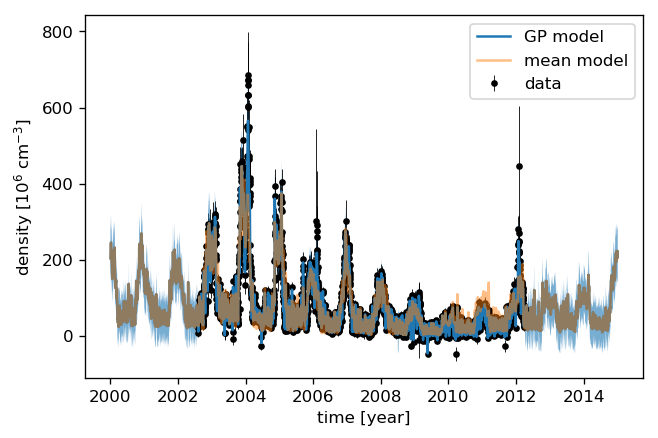

In [25]:
# Mean model prediction
mean_pred = model.get_value(times)

# GP predictive mean and variance
mu, var = gpmodel.predict(data, times, return_var=True)
# add 10% for noisy targets
std = np.sqrt(var + (0.1 * mu)**2)

plt.errorbar(time, data, yerr=2. * errs, fmt='.k', elinewidth=0.5, zorder=1, label="data")
plt.plot(times, mu, label="GP model")
plt.fill_between(times, mu - 2 * std, mu + 2 * std, alpha=0.6)
plt.plot(times, mean_pred, alpha=0.5, label="mean model")
plt.ylabel("density [10$^{{{0:.0f}}}$ ${1}$]"
           .format(-np.log10(data_scale), data_ts.NO_DENS.attrs["units"]))
plt.xlabel("time [year]")
plt.legend();

Let's look at the residuals to see how well the model fits the data.
We therefore "predict" the data at the measurement times.

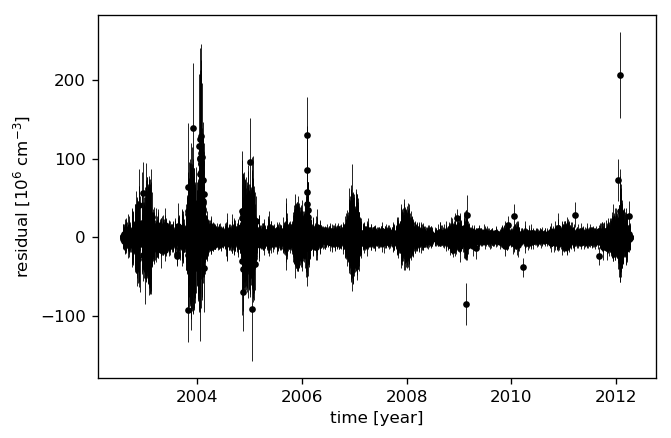

In [26]:
mu, var = gpmodel.predict(data, time, return_var=True)
# again, 10% for noisy targets
std = np.sqrt(var + (0.1 * mu)**2)

plt.errorbar(time, data - mu, yerr=2 * std, fmt='.k', elinewidth=0.5)
plt.ylabel("residual [10$^{{{0:.0f}}}$ ${1}$]"
           .format(-np.log10(data_scale), data_ts.NO_DENS.attrs["units"]))
plt.xlabel("time [year]");

## MCMC sampling

The Markov-Chain Monte-Carlo sampling is done with [emcee](https://emcee.rtfd.io),
and we set up the sampler to something that does not take too long on a single machine.
You can change the number of walkers or increase the number of threads to speed up the sampling.

In [27]:
import emcee

initial = gpmodel.get_parameter_vector()
ndim, nwalkers = len(initial), 48
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost, args=(data, gpmodel), threads=2)

In [28]:
print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 200)

sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 800);

Running burn-in...
Running production...


### Sampled results

We use the `corner` module to plot the sampled parameter distributions.

In [29]:
import corner

names = gpmodel.get_parameter_names()
cols = model.get_parameter_names()
# the indices of the mean model parameters
inds = np.array([names.index("mean:" + k) for k in cols])

This figure shows the sampled distributions of the mean model parameters only,
excluding the Gaussian Process kernel's parameters.
The "true" values are taken from the `scipy.optimize.minimize` fit above.

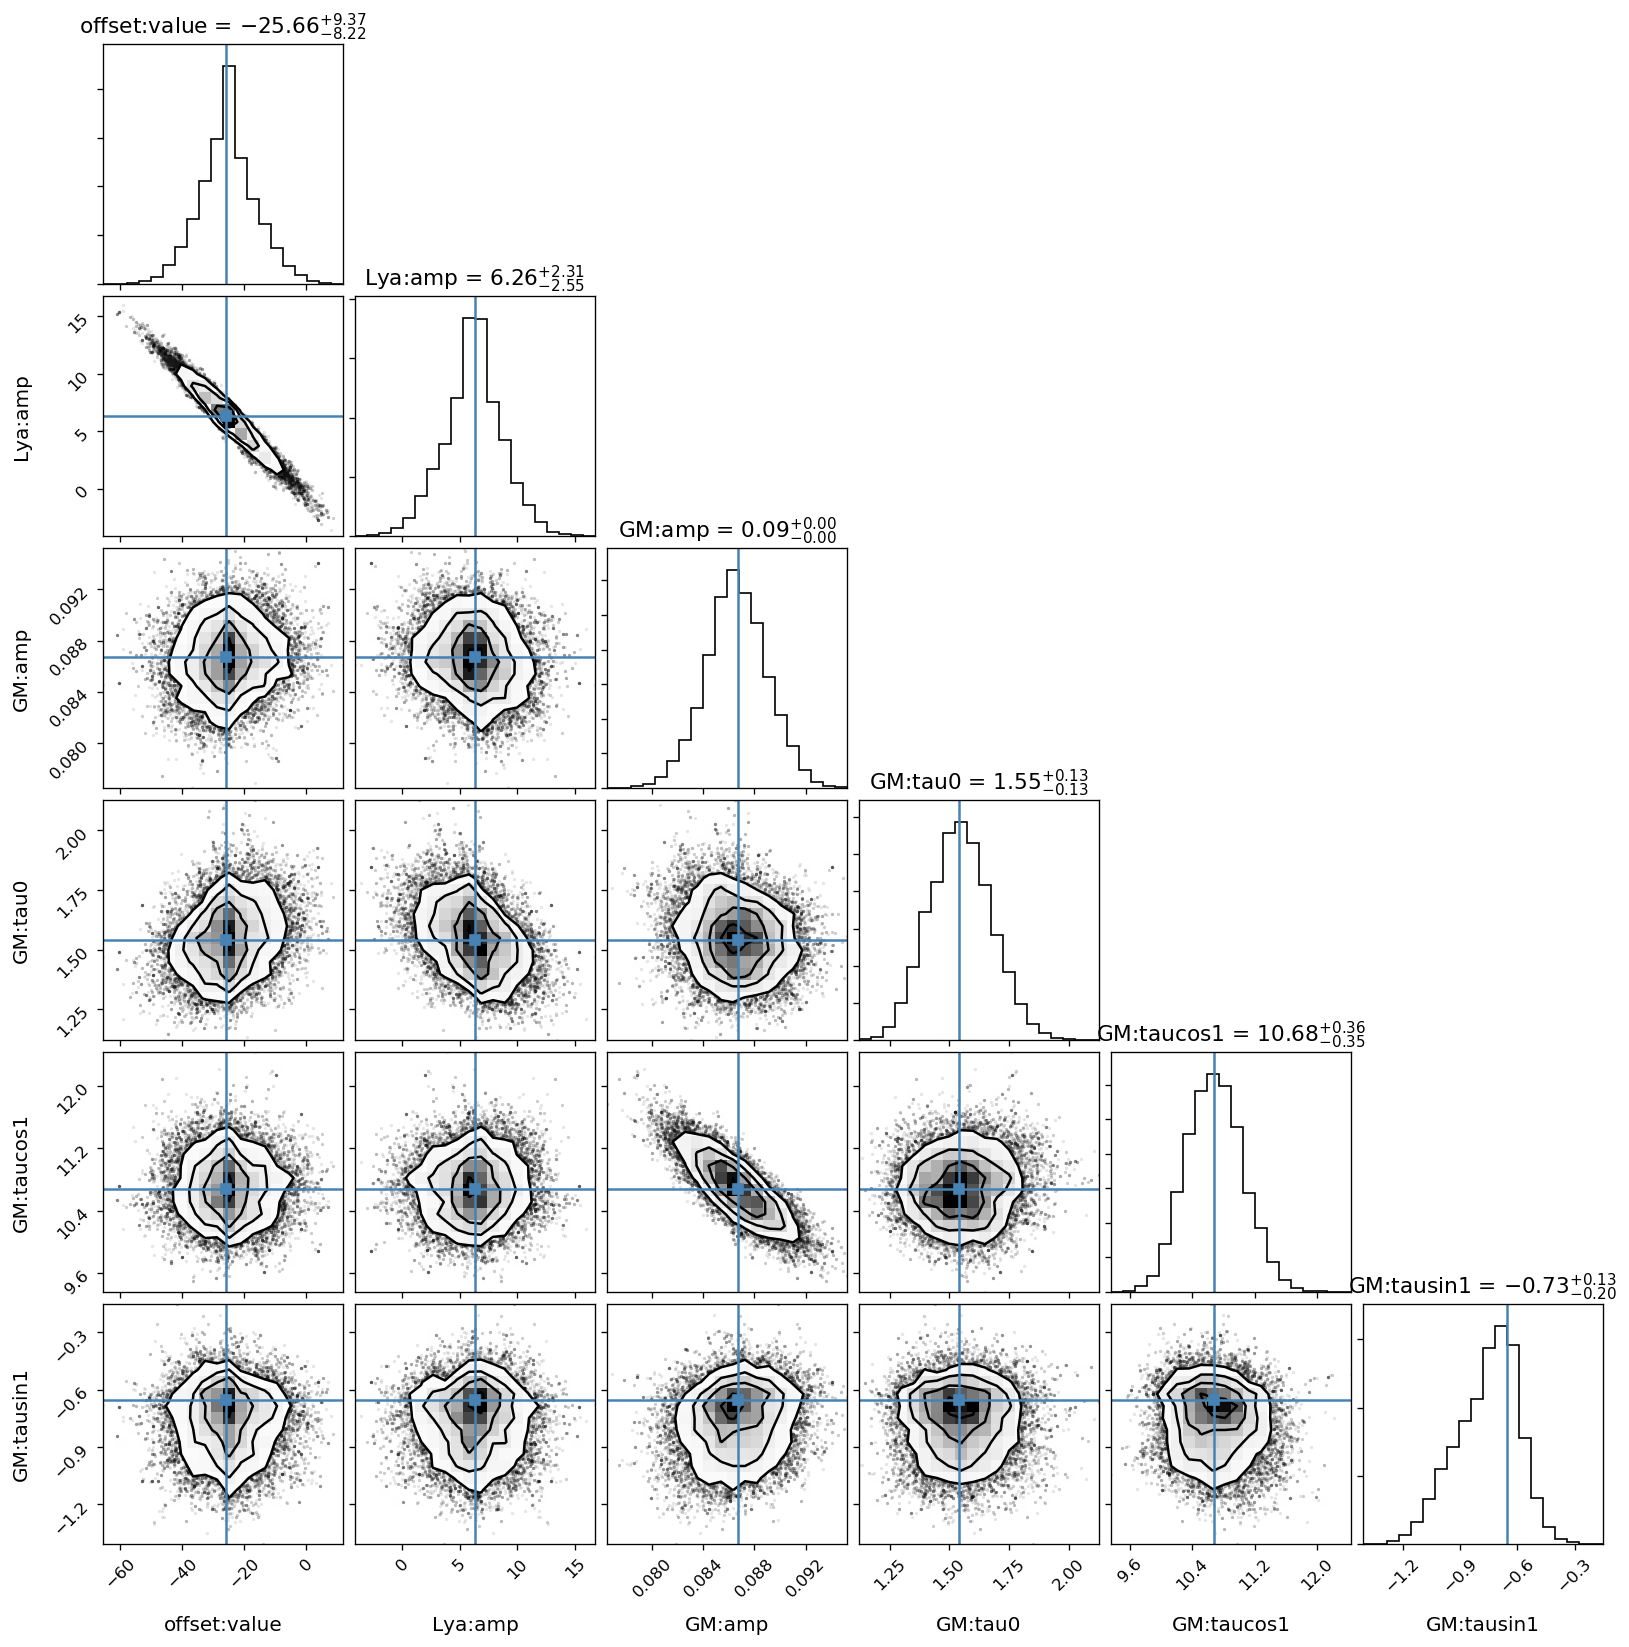

In [30]:
# only mean model parameters
corner.corner(sampler.flatchain[:, inds],
              show_titles=True,
              title_kwargs={"fontsize": 13},
              truths=res_opt.x[inds],
              label_kwargs={"fontsize": 12},
              labels=cols);

To have an idea about the variance of the predictions,
we select a few samples from the paramter distributions
which were just sampled by `emcee`.
We then draw a random sample from the corresponding
multivariate normal distribution with the predictive mean
and covariance (plus the data variance) as parameters.

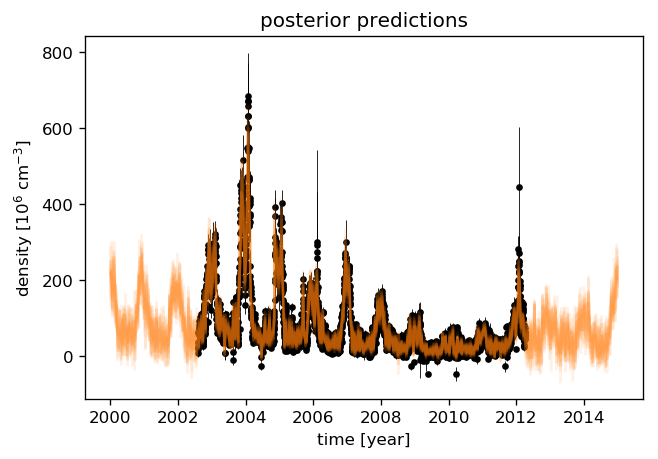

In [31]:
# Plot the data.
plt.errorbar(time, data, yerr=2 * errs, fmt=".k", elinewidth=0.5, zorder=1, label="data")

# Plot 12 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=12)]:
    gpmodel.set_parameter_vector(s)
    mu, cov = gpmodel.predict(data, times[::10])
    cov[np.diag_indices_from(cov)] += (0.1 * mu)**2
    sampl = np.random.multivariate_normal(mu, cov)
    plt.plot(times[::10], sampl, color="C1", alpha=0.1)

plt.ylabel("density [10$^{{{0:.0f}}}$ ${1}$]"
           .format(-np.log10(data_scale), data_ts.NO_DENS.attrs["units"]))
plt.xlabel("time [year]")
plt.title("posterior predictions");